# Coursework for MRI reconstruction (Autumn 2019)

In this tutorial, we provide the data loader to read and process the MRI data in order to ease the difficulty of training your network. By providing this, we hope you focus more on methodology development. Please feel free to change it to suit what you need.

In [1]:
#ALL IMPORTS
import h5py, os
from functions import transforms as T
from functions.subsample import MaskFunc
from scipy.io import loadmat
from torch.utils.data import DataLoader
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn
from torch.nn import functional as F
from matplotlib import pyplot as plt
#cuda
import torch.optim as optim
device = 'cuda:0' if torch.cuda.is_available() else 'cpu' #'cpu'

In [2]:
##### UNET MODEL ######

class ConvBlock(nn.Module):
    """
    A Convolutional Block that consists of two convolution layers each followed by
    instance normalization, relu activation and dropout.
    """

    def __init__(self, in_chans, out_chans, drop_prob):
        """
        Args:
            in_chans (int): Number of channels in the input.
            out_chans (int): Number of channels in the output.
            drop_prob (float): Dropout probability.
        """
        super().__init__()

        self.in_chans = in_chans
        self.out_chans = out_chans
        self.drop_prob = drop_prob

        self.layers = nn.Sequential(
            nn.Conv2d(in_chans, out_chans, kernel_size=3, padding=1),
            nn.InstanceNorm2d(out_chans),
            nn.ReLU(),
            nn.Dropout2d(drop_prob),
            nn.Conv2d(out_chans, out_chans, kernel_size=3, padding=1),
            nn.InstanceNorm2d(out_chans),
            nn.ReLU(),
            nn.Dropout2d(drop_prob)
        )

    def forward(self, input):
        """
        Args:
            input (torch.Tensor): Input tensor of shape [batch_size, self.in_chans, height, width]

        Returns:
            (torch.Tensor): Output tensor of shape [batch_size, self.out_chans, height, width]
        """
        return self.layers(input)

    def __repr__(self):
        return f'ConvBlock(in_chans={self.in_chans}, out_chans={self.out_chans}, ' \
            f'drop_prob={self.drop_prob})'


class UnetModel(nn.Module):
    """
    PyTorch implementation of a U-Net model.

    This is based on:
        Olaf Ronneberger, Philipp Fischer, and Thomas Brox. U-net: Convolutional networks
        for biomedical image segmentation. In International Conference on Medical image
        computing and computer-assisted intervention, pages 234–241. Springer, 2015.
    """

    def __init__(self, in_chans, out_chans, chans, num_pool_layers, drop_prob):
        """
        Args:
            in_chans (int): Number of channels in the input to the U-Net model.
            out_chans (int): Number of channels in the output to the U-Net model.
            chans (int): Number of output channels of the first convolution layer.
            num_pool_layers (int): Number of down-sampling and up-sampling layers.
            drop_prob (float): Dropout probability.
        """
        super().__init__()

        self.in_chans = in_chans
        self.out_chans = out_chans
        self.chans = chans
        self.num_pool_layers = num_pool_layers
        self.drop_prob = drop_prob

        self.down_sample_layers = nn.ModuleList([ConvBlock(in_chans, chans, drop_prob)])
        ch = chans
        for i in range(num_pool_layers - 1):
            self.down_sample_layers += [ConvBlock(ch, ch * 2, drop_prob)]
            ch *= 2
        self.conv = ConvBlock(ch, ch, drop_prob)

        self.up_sample_layers = nn.ModuleList()
        for i in range(num_pool_layers - 1):
            self.up_sample_layers += [ConvBlock(ch * 2, ch // 2, drop_prob)]
            ch //= 2
        self.up_sample_layers += [ConvBlock(ch * 2, ch, drop_prob)]
        self.conv2 = nn.Sequential(
            nn.Conv2d(ch, ch // 2, kernel_size=1),
            nn.Conv2d(ch // 2, out_chans, kernel_size=1),
            nn.Conv2d(out_chans, out_chans, kernel_size=1),
        )

    def forward(self, input):
        """
        Args:
            input (torch.Tensor): Input tensor of shape [batch_size, self.in_chans, height, width]

        Returns:
            (torch.Tensor): Output tensor of shape [batch_size, self.out_chans, height, width]
        """
        stack = []
        output = input
        # Apply down-sampling layers
        for layer in self.down_sample_layers:
            output = layer(output)
            stack.append(output)
            output = F.max_pool2d(output, kernel_size=2)

        output = self.conv(output)

        # Apply up-sampling layers
        for layer in self.up_sample_layers:
            output = F.interpolate(output, scale_factor=2, mode='bilinear', align_corners=False)
            output = torch.cat([output, stack.pop()], dim=1)
            output = layer(output)
        return self.conv2(output)

In [3]:
#pre-defined ultily functions used in creating the neural net

def show_slices(data, slice_nums, cmap=None): # visualisation
    fig = plt.figure(figsize=(15,10))
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)
        plt.axis('off')

def get_epoch_batch(subject_id, acc, center_fract, use_seed=True):
    ''' random select a few slices (batch_size) from each volume'''

    fname, rawdata_name, slice = subject_id  
    
    with h5py.File(rawdata_name, 'r') as data:
        rawdata = data['kspace'][slice]
                      
    slice_kspace = T.to_tensor(rawdata).unsqueeze(0)
    S, Ny, Nx, ps = slice_kspace.shape

    # apply random mask
    shape = np.array(slice_kspace.shape)
    mask_func = MaskFunc(center_fractions=[center_fract], accelerations=[acc])
    seed = None if not use_seed else tuple(map(ord, fname))
    mask = mask_func(shape, seed)
      
    # undersample
    masked_kspace = torch.where(mask == 0, torch.Tensor([0]), slice_kspace)
    masks = mask.repeat(S, Ny, 1, ps)

    img_gt, img_und = T.ifft2(slice_kspace), T.ifft2(masked_kspace)

    # perform data normalization which is important for network to learn useful features
    # during inference there is no ground truth image so use the zero-filled recon to normalize
    norm = T.complex_abs(img_und).max()
    if norm < 1e-6: norm = 1e-6
    
#     A = cropped_img_und.squeeze().detach().cpu()
#     C = cropped_gt.squeeze().squeeze().detach().cpu()
    
    # normalized data
    img_gt, img_und, rawdata_und = img_gt/norm, img_und/norm, masked_kspace/norm
    
    volume_image_abs = T.complex_abs(img_gt) 
    cropped_gt = T.center_crop(volume_image_abs, [320, 320])
    cropped_gt = cropped_gt
        
    volume_image_abs = T.complex_abs(img_und) 
    cropped_img_und = T.center_crop(volume_image_abs, [320, 320])
    cropped_img_und = cropped_img_und
        
    return cropped_gt,cropped_img_und, norm
  #return img_gt.squeeze(0), img_und.squeeze(0), rawdata_und.squeeze(0), masks.squeeze(0), norm

class MRIDataset(DataLoader):
    def __init__(self, data_list, acceleration, center_fraction, use_seed):
        self.data_list = data_list
        self.acceleration = acceleration
        self.center_fraction = center_fraction
        self.use_seed = use_seed

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        subject_id = self.data_list[idx]
        return get_epoch_batch(subject_id, self.acceleration, self.center_fraction, self.use_seed)
    
    def load_data_path(train_data_path, val_data_path):
        """ Go through each subset (training, validation) and list all 
        the file names, the file paths and the slices of subjects in the training and validation sets 
        """

        data_list = {}
        train_and_val = ['train', 'val']
        data_path = [train_data_path, val_data_path]

        for i in range(len(data_path)):

            data_list[train_and_val[i]] = []

            which_data_path = data_path[i]

            for fname in sorted(os.listdir(which_data_path)):

                subject_data_path = os.path.join(which_data_path, fname)

                if not os.path.isfile(subject_data_path): continue 

                with h5py.File(subject_data_path, 'r') as data:
                    num_slice = data['kspace'].shape[0]

                # the first 5 slices are mostly noise so it is better to exlude them
                data_list[train_and_val[i]] += [(fname, subject_data_path, slice) for slice in range(5, num_slice)]

        return data_list  
   
    
from skimage.measure import compare_ssim  
def ssim(gt, pred):
    """ Compute Structural Similarity Index Metric (SSIM). """
    return compare_ssim(
        gt.transpose(1, 2, 0), pred.transpose(1, 2, 0), multichannel=True, data_range=gt.max()
    )  


def show_slices(data, slice_nums, cmap=None): # visualisation
    fig = plt.figure(figsize=(15,10))
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)
        plt.axis('off')

In [4]:

torch.manual_seed(42)

# Now we can create a model
model = UnetModel(
    in_chans = 1,
    out_chans = 1,
    chans = 32,
    num_pool_layers = 4,
    drop_prob = 0 ).to(device) # FirstModel().to(device)

# # we can also inspect its parameters
# print("Before training: \n", model.state_dict())

In [5]:
#Set initial path for the fullset of training data
file_path = '/data/local/NC2019MRI/train'

# Shuffle sets, and split train_index into train and validation 80:20 respectively 
numfiles_all = len(os.listdir(file_path))
print (numfiles_all)
indx = np.arange(numfiles_all)
np.random.shuffle(indx)

split_80_20 = 0.8 * numfiles_all
split_80_20 = int(split_80_20)
print(split_80_20)

np.random.seed(42)

train_inx = indx[:split_80_20]
val_inx = indx[split_80_20:]

print("train_inx",train_inx)
print("val_inx",val_inx)


70
56
train_inx [59 37  6 12  8  9 11 64 10 60 36 41 66 49 29 39 17 69 47 56 44 13 16 28
 46 32 15 50  4 51  5 18 35  3 14 21 63 45 31  7 40 23 67 68 53 19 38 62
  1 34 33 61 57 42 27  0]
val_inx [30 52 26 58  2 65 20 22 43 55 48 54 24 25]


In [6]:

    train_data_list = {}
    train_data_list['val']= [0] * len(val_inx)
    train_data_list['train'] = [0] * len(train_inx)
    count = 0  
    
    for fname in sorted(os.listdir(file_path)): 
        subject_path = os.path.join(file_path, fname)
        with h5py.File(subject_path,  "r") as hf:
             total_num_slices = hf['kspace'].shape[0]

                
        for i in range(len(train_inx)):
            if (train_inx[i] == count):
                train_data_list['train'][i] = (file_path+ "/" +fname, fname, total_num_slices)  
                break
                
        for k in range(len(val_inx)):
            if (val_inx[k] == count):
                train_data_list['val'][k] = (file_path+ "/"+ fname, fname, total_num_slices)
                break
        count = count +1

            
    train_data_final ={}         
    train_data_final['train'] = []  
    train_data_final['val'] = []  
           
    for i in range (len(train_data_list['train'])):
        for slice in range (5,train_data_list['train'][i][2]):
            train_data_final['train'].append((train_data_list['train'][i][1], train_data_list['train'][i][0], (slice)))
        

    for i in range (len(train_data_list['val'])):
        for slice in range (5,train_data_list['val'][i][2]):
            train_data_final['val'].append((train_data_list['val'][i][1], train_data_list['val'][i][0], slice))

            

In [7]:
print("VALIDATION SET")
valcount = 0
for i in range (len(train_data_final['val'])):
    print(" count : ",valcount,"  ", train_data_final['val'][i])
    valcount = valcount + 1
    
print("")
print("")
print("")
print("")

train_count = 0    
print("TRAIN SET")
for i in range (len(train_data_final['train'])):
    print(" count : ",train_count,"  ", train_data_final['train'][i])
    train_count = train_count + 1


VALIDATION SET
 count :  0    ('file1000280.h5', '/data/local/NC2019MRI/train/file1000280.h5', 5)
 count :  1    ('file1000280.h5', '/data/local/NC2019MRI/train/file1000280.h5', 6)
 count :  2    ('file1000280.h5', '/data/local/NC2019MRI/train/file1000280.h5', 7)
 count :  3    ('file1000280.h5', '/data/local/NC2019MRI/train/file1000280.h5', 8)
 count :  4    ('file1000280.h5', '/data/local/NC2019MRI/train/file1000280.h5', 9)
 count :  5    ('file1000280.h5', '/data/local/NC2019MRI/train/file1000280.h5', 10)
 count :  6    ('file1000280.h5', '/data/local/NC2019MRI/train/file1000280.h5', 11)
 count :  7    ('file1000280.h5', '/data/local/NC2019MRI/train/file1000280.h5', 12)
 count :  8    ('file1000280.h5', '/data/local/NC2019MRI/train/file1000280.h5', 13)
 count :  9    ('file1000280.h5', '/data/local/NC2019MRI/train/file1000280.h5', 14)
 count :  10    ('file1000280.h5', '/data/local/NC2019MRI/train/file1000280.h5', 15)
 count :  11    ('file1000280.h5', '/data/local/NC2019MRI/train/f

 count :  167    ('file1000073.h5', '/data/local/NC2019MRI/train/file1000073.h5', 14)
 count :  168    ('file1000073.h5', '/data/local/NC2019MRI/train/file1000073.h5', 15)
 count :  169    ('file1000073.h5', '/data/local/NC2019MRI/train/file1000073.h5', 16)
 count :  170    ('file1000073.h5', '/data/local/NC2019MRI/train/file1000073.h5', 17)
 count :  171    ('file1000073.h5', '/data/local/NC2019MRI/train/file1000073.h5', 18)
 count :  172    ('file1000073.h5', '/data/local/NC2019MRI/train/file1000073.h5', 19)
 count :  173    ('file1000073.h5', '/data/local/NC2019MRI/train/file1000073.h5', 20)
 count :  174    ('file1000073.h5', '/data/local/NC2019MRI/train/file1000073.h5', 21)
 count :  175    ('file1000073.h5', '/data/local/NC2019MRI/train/file1000073.h5', 22)
 count :  176    ('file1000073.h5', '/data/local/NC2019MRI/train/file1000073.h5', 23)
 count :  177    ('file1000073.h5', '/data/local/NC2019MRI/train/file1000073.h5', 24)
 count :  178    ('file1000073.h5', '/data/local/NC201

 count :  746    ('file1000477.h5', '/data/local/NC2019MRI/train/file1000477.h5', 23)
 count :  747    ('file1000477.h5', '/data/local/NC2019MRI/train/file1000477.h5', 24)
 count :  748    ('file1000477.h5', '/data/local/NC2019MRI/train/file1000477.h5', 25)
 count :  749    ('file1000477.h5', '/data/local/NC2019MRI/train/file1000477.h5', 26)
 count :  750    ('file1000477.h5', '/data/local/NC2019MRI/train/file1000477.h5', 27)
 count :  751    ('file1000477.h5', '/data/local/NC2019MRI/train/file1000477.h5', 28)
 count :  752    ('file1000477.h5', '/data/local/NC2019MRI/train/file1000477.h5', 29)
 count :  753    ('file1000477.h5', '/data/local/NC2019MRI/train/file1000477.h5', 30)
 count :  754    ('file1000477.h5', '/data/local/NC2019MRI/train/file1000477.h5', 31)
 count :  755    ('file1000477.h5', '/data/local/NC2019MRI/train/file1000477.h5', 32)
 count :  756    ('file1000291.h5', '/data/local/NC2019MRI/train/file1000291.h5', 5)
 count :  757    ('file1000291.h5', '/data/local/NC2019

 count :  1270    ('file1000247.h5', '/data/local/NC2019MRI/train/file1000247.h5', 34)
 count :  1271    ('file1000247.h5', '/data/local/NC2019MRI/train/file1000247.h5', 35)
 count :  1272    ('file1000759.h5', '/data/local/NC2019MRI/train/file1000759.h5', 5)
 count :  1273    ('file1000759.h5', '/data/local/NC2019MRI/train/file1000759.h5', 6)
 count :  1274    ('file1000759.h5', '/data/local/NC2019MRI/train/file1000759.h5', 7)
 count :  1275    ('file1000759.h5', '/data/local/NC2019MRI/train/file1000759.h5', 8)
 count :  1276    ('file1000759.h5', '/data/local/NC2019MRI/train/file1000759.h5', 9)
 count :  1277    ('file1000759.h5', '/data/local/NC2019MRI/train/file1000759.h5', 10)
 count :  1278    ('file1000759.h5', '/data/local/NC2019MRI/train/file1000759.h5', 11)
 count :  1279    ('file1000759.h5', '/data/local/NC2019MRI/train/file1000759.h5', 12)
 count :  1280    ('file1000759.h5', '/data/local/NC2019MRI/train/file1000759.h5', 13)
 count :  1281    ('file1000759.h5', '/data/loca

In [8]:
######loads_train_data #######
if __name__ == '__main__':
    
    acc = 8
    cen_fract = 0.04
    seed = False # random masks for each slice 
    num_workers = 12 
    
    #
    train_dataset = MRIDataset(train_data_final['train'], acceleration=acc, center_fraction=cen_fract, use_seed=seed)
    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=3, num_workers=num_workers) 
    
    validation_dataset = MRIDataset(train_data_final['val'], acceleration=acc, center_fraction=cen_fract, use_seed=seed)
    validation_loader = DataLoader(validation_dataset, shuffle=True, batch_size=3, num_workers=num_workers)  

In [9]:

    train_data_list = {}
    train_data_list['val']= [0] * len(val_inx)
    train_data_list['train'] = [0] * len(train_inx)
    count = 0  
    
    for fname in sorted(os.listdir(file_path)): 
        subject_path = os.path.join(file_path, fname)
        with h5py.File(subject_path,  "r") as hf:
             total_num_slices = hf['kspace'].shape[0]

                
        for i in range(len(train_inx)):
            if (train_inx[i] == count):
                train_data_list['train'][i] = (file_path+ "/" +fname, fname, total_num_slices)  
                break
                
        for k in range(len(val_inx)):
            if (val_inx[k] == count):
                train_data_list['val'][k] = (file_path+ "/"+ fname, fname, total_num_slices)
                break
        count = count +1

            
    train_data_final ={}         
    train_data_final['train'] = []  
    train_data_final['val'] = []  
           
    for i in range (len(train_data_list['train'])):
        for slice in range (5,train_data_list['train'][i][2]):
            train_data_final['train'].append((train_data_list['train'][i][1], train_data_list['train'][i][0], (slice)))
        

    for i in range (len(train_data_list['val'])):
        for slice in range (5,train_data_list['val'][i][2]):
            train_data_final['val'].append((train_data_list['val'][i][1], train_data_list['val'][i][0], slice))

            

In [13]:
#set training
%matplotlib inline 
print("HELOLOOO")
# set learning rate
#lr = 1e-4
# lr = 1e-3
# lr = 1e-2
lr = 1e-1

#set number of epoches, i.e., number of times we iterate through the training set
epoches = 3

# # We use mean square error (MSELoss)
loss_fn = nn.MSELoss(reduction='mean').to(device)

# Optimisers
#optimiser = torch.optim.RMSprop(model.parameters(), lr=lr)
optimiser = optim.SGD(model.parameters(), lr=lr)





#Lists for plotting val/train SSIM/Loss/prEpoch
train_av_epoch_ssim_list = []
train_av_epoch_loss_list = []

val_av_epoch_ssim_list = []
val_av_epoch_loss_list = []

epoch_count = 0

#Model training
for epoch in range(epoches):
   
    model.train()
    
    train_total_loss = 0
    train_total_ssim = 0
    train_iterations= 0
    
    val_total_loss = 0
    val_total_ssim = 0
    val_iterations= 0
    
    #Training
    for data in train_loader:

        # set the model to training mode
        img_gt, img_und, _ = data
        
        #Reconstruction/prediction from undersampled data
        img_gt = img_gt.to(device) 
        img_und.to(device) 
        optimiser.zero_grad()
        print(train_iterations, '!!!!!size:',img_und.size(), img_gt.size())
        y_pred = model(img_und.to(device))
        
                #visualise 
        # 0 = UNDERSAMPLED. 1 = PREDICTION. 2 = GROUND_TRUTH
        #if train_iterations % 10 == 1:
        A = img_und.squeeze().squeeze().numpy()[0:1,:,:]
        B = y_pred.squeeze().squeeze().squeeze(0).detach().cpu()
        
        B = y_pred.squeeze().data.cpu().numpy()
        B = B[0:1, :, :]
        #print(B.shape)
        
        C = img_gt.squeeze().squeeze().squeeze(0).cpu().numpy()[0:1,:,:]
        #print("A",A.shape,"B",B.shape, "C",C.shape)
        #all_imgs = torch.stack([A.squeeze(),B,C], dim=0)
        #print(all_imgs.shape)
        
        all_imgs = np.concatenate([A,B,C], axis=0)
        
        #print(all_imgs.shape)
        
        #show_slices(all_imgs, [0,1,2], cmap='gray')
        #plt.pause(1)
        #print("2")
        
        #calculate the loss from training data
        loss = loss_fn(img_gt.to(device), y_pred)
        loss.backward() 
        optimiser.step()
        
        #calculate total loss for epoch to generate average loss
        train_total_loss = train_total_loss + loss.item()
        
        # calculate total ssim value for epoch to generate average ssim
        ssim_value = ssim(C,B)
        train_total_ssim = train_total_ssim + ssim_value
     

        #count
        train_iterations = train_iterations +1
        
        
    train_av_ssim = train_total_ssim/train_iterations
    train_av_loss = train_total_loss/train_iterations
    
    train_av_epoch_ssim_list.append(train_av_ssim)
    train_av_epoch_loss_list.append(train_av_loss)
    
    
    #Validation 
    with torch.no_grad():
        #set to evaluation mode
        model.eval()
        for data in validation_loader:

            #from data loader
            img_gt, img_und, _ = data
            
            #Reconstruction/prediction from undersampled data
            img_gt = img_gt.to(device) 
            img_und.to(device) 
            optimiser.zero_grad()
            print('!!!!!size:',img_und.size(), img_gt.size())
            y_pred = model(img_und.to(device))
            
            A = img_und.squeeze().squeeze().numpy()[0:1,:,:]
            B = y_pred.squeeze().squeeze().squeeze(0).detach().cpu()
        
            B = y_pred.squeeze().data.cpu().numpy()
            B = B[0:1, :, :]
            
        #print(B.shape)
        
            C = img_gt.squeeze().squeeze().squeeze(0).cpu().numpy()[0:1,:,:]
            all_imgs = np.concatenate([A,B,C], axis=0)
            
            
             #calculate the loss from validation data
            val_loss = loss_fn(img_gt.to(device), y_pred)
            optimiser.step()
            
            #calculate total loss for epoch to generate average loss
            val_total_loss = val_total_loss + loss.item()
        
        
#             A = img_und.unsqueeze(1).n
#             B = y_pred.squeeze().squeeze().detach().cpu().numpy()
#             C = img_gt.squeeze().squeeze().cpu().numpy()
#             #print(A.shape, B.shape, C.shape)
            
            #all_imgs = torch.stack([A.squeeze(),B,C], dim=0)
            #print("1")
           # show_slices(all_imgs, [0,1,2], cmap='gray')
            #plt.pause(1)
            #print("2")
            #calculate total ssim value for epoch to generate average ssim
            ssim_value = ssim(C,B)
            val_total_ssim = val_total_ssim + ssim_value
            
            #count
            val_iterations = val_iterations + 1
            
    val_av_ssim = val_total_ssim/val_iterations
    val_av_loss = val_total_loss/val_iterations
    
    val_av_epoch_ssim_list.append(val_av_ssim)
    val_av_epoch_loss_list.append(val_av_loss)
    
#     epoch_count = epoch_count + 1
    print("epoch_count ", epoch_count)

print("epoch: ", epoch_count,"train_av_epoch_ssim_list :", train_av_epoch_ssim_list)
print("epoch: ", epoch_count,"train_av_epoch_loss_list :", train_av_epoch_loss_list)
print("epoch: ", epoch_count,"val_av_epoch_ssim_list :", val_av_epoch_ssim_list)
print("epoch: ", epoch_count,"val_av_epoch_loss_list :", val_av_epoch_loss_list)


HELOLOOO
0 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
1 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])


/bham/modules/roots/neural-comp/2019-20/lib/python3.6/site-packages/ipykernel_launcher.py:103: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


2 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
3 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
4 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
5 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
6 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
7 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
8 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
9 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
10 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
11 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
12 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
13 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
14 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
15 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])


116 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
117 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
118 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
119 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
120 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
121 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
122 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
123 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
124 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
125 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
126 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
127 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
128 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
129 !!!!!size: torch.Size([3, 1, 320, 320]) torch.S

230 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
231 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
232 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
233 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
234 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
235 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
236 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
237 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
238 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
239 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
240 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
241 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
242 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
243 !!!!!size: torch.Size([3, 1, 320, 320]) torch.S

344 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
345 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
346 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
347 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
348 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
349 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
350 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
351 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
352 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
353 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
354 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
355 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
356 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
357 !!!!!size: torch.Size([3, 1, 320, 320]) torch.S

458 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
459 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
460 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
461 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
462 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
463 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
464 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
465 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
466 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
467 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
468 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
469 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
470 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
471 !!!!!size: torch.Size([3, 1, 320, 320]) torch.S

572 !!!!!size: torch.Size([2, 1, 320, 320]) torch.Size([2, 1, 320, 320])
!!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
!!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
!!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
!!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
!!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
!!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
!!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
!!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
!!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
!!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
!!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
!!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
!!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
!!!!!size: torch.Size([3, 1, 3

!!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
!!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
!!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
!!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
!!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
!!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
!!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
!!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
!!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
!!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
!!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
!!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
!!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
!!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
!!!!!size: torch.Size([3, 1, 320, 

98 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
99 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
100 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
101 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
102 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
103 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
104 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
105 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
106 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
107 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
108 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
109 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
110 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
111 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Siz

212 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
213 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
214 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
215 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
216 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
217 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
218 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
219 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
220 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
221 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
222 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
223 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
224 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
225 !!!!!size: torch.Size([3, 1, 320, 320]) torch.S

326 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
327 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
328 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
329 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
330 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
331 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
332 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
333 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
334 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
335 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
336 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
337 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
338 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
339 !!!!!size: torch.Size([3, 1, 320, 320]) torch.S

440 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
441 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
442 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
443 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
444 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
445 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
446 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
447 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
448 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
449 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
450 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
451 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
452 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
453 !!!!!size: torch.Size([3, 1, 320, 320]) torch.S

553 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
554 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
555 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
556 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
557 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
558 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
559 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
560 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
561 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
562 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
563 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
564 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
565 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
566 !!!!!size: torch.Size([3, 1, 320, 320]) torch.S

!!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
!!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
!!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
!!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
!!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
!!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
!!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
!!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
!!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
!!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
!!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
!!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
!!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
!!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
!!!!!size: torch.Size([3, 1, 320, 

80 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
81 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
82 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
83 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
84 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
85 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
86 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
87 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
88 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
89 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
90 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
91 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
92 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
93 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320

194 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
195 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
196 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
197 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
198 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
199 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
200 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
201 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
202 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
203 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
204 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
205 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
206 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
207 !!!!!size: torch.Size([3, 1, 320, 320]) torch.S

308 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
309 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
310 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
311 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
312 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
313 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
314 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
315 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
316 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
317 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
318 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
319 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
320 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
321 !!!!!size: torch.Size([3, 1, 320, 320]) torch.S

422 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
423 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
424 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
425 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
426 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
427 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
428 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
429 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
430 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
431 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
432 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
433 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
434 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
435 !!!!!size: torch.Size([3, 1, 320, 320]) torch.S

536 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
537 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
538 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
539 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
540 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
541 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
542 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
543 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
544 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
545 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
546 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
547 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
548 !!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
549 !!!!!size: torch.Size([3, 1, 320, 320]) torch.S

!!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
!!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
!!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
!!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
!!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
!!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
!!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
!!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
!!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
!!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
!!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
!!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
!!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
!!!!!size: torch.Size([3, 1, 320, 320]) torch.Size([3, 1, 320, 320])
!!!!!size: torch.Size([3, 1, 320, 

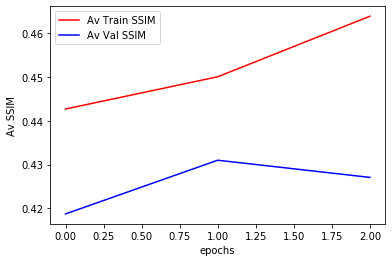

In [14]:
#VALIDATION VS TRAINING SSIM COMPARISON
plt.plot(range(len(train_av_epoch_ssim_list)), train_av_epoch_ssim_list,'r', label = "Av Train SSIM")
plt.plot(range(len(val_av_epoch_ssim_list)), val_av_epoch_ssim_list,'b', label = "Av Val SSIM")
plt.xlabel("epochs")
plt.ylabel("Av SSIM")
plt.legend()
plt.show()

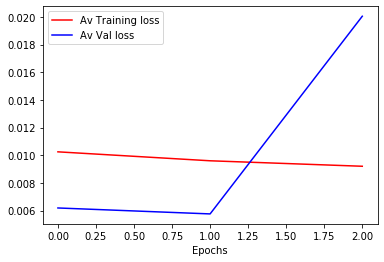

In [15]:
#VALIDATION VS TRAINING LOSS COMPARISON
plt.plot(range(len(train_av_epoch_loss_list)), train_av_epoch_loss_list,'r', label = "Av Training loss")
plt.plot(range(len(val_av_epoch_loss_list)), val_av_epoch_loss_list,'b', label = "Av Val loss")
plt.xlabel("Epochs")

plt.legend()
plt.show()

In [ ]:
torch.save(model,"unet_model_save.pkl")

### 